In [20]:
import matplotlib.pyplot as plt

from knetworks import knetworks, Network
import numpy as np
from testdata.generator import generateFromGenFile
import torch
import os
%matplotlib inline

%config InlineBackend.figure_format='retina'
device = torch.device("cuda")

In [2]:
filename = os.getcwd() + "/../" + "allproducts.txt" #may not work for windows
with open(filename, "r") as file:
    f = file.read()
    products = f.split("\n")

products = [p.upper() for p in products]

features = []
vectors = []
data = [[] for i in range(19)] # warning #cleancode
for f in range(1, 20):
    file = open("testdata/gu_" + str(f) + ".txt", "r") 
    lines = file.readlines()
    features = sorted(str(lines[0]).replace(" ", "").upper().strip().split(","))
    vect = []
    for l in range(len(lines)-1):
        data[f-1].append([])
        vec = lines[l+1].upper().split(",")
        for i in range(len(vec)):
            if int(float(vec[i])) == 1:
                data[f-1][l].append(features[i])
    vectors.append(np.array(vect))

In [3]:
vectors = [np.array([np.zeros(len(products), dtype=np.int) for gr_list in range(len(data[user]))]) for user in range(len(data))]
for i,x in enumerate(data):
    for j,y in enumerate(x):
        for k,f in enumerate(products):
            if f in y:
                vectors[i][j][k] = 1

In [6]:
knet = knetworks(6, vectors[:-4], len(products), device) # create a knetworks object

In [7]:
#knet.load("saves") # loading a savestate

In [8]:
knet.fit() # fit the centroids to the data (using 7 datapoints for the mean)

<ipython-input-10-92bcd96a7d6c>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  axes[i][j].plot(np.array(vectors)[i][:,j])
<ipython-input-10-92bcd96a7d6c>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  axes[i][j].plot(np.array(vectors)[i][:,j])
<ipython-input-10-92bcd96a7d6c>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  axes[i][

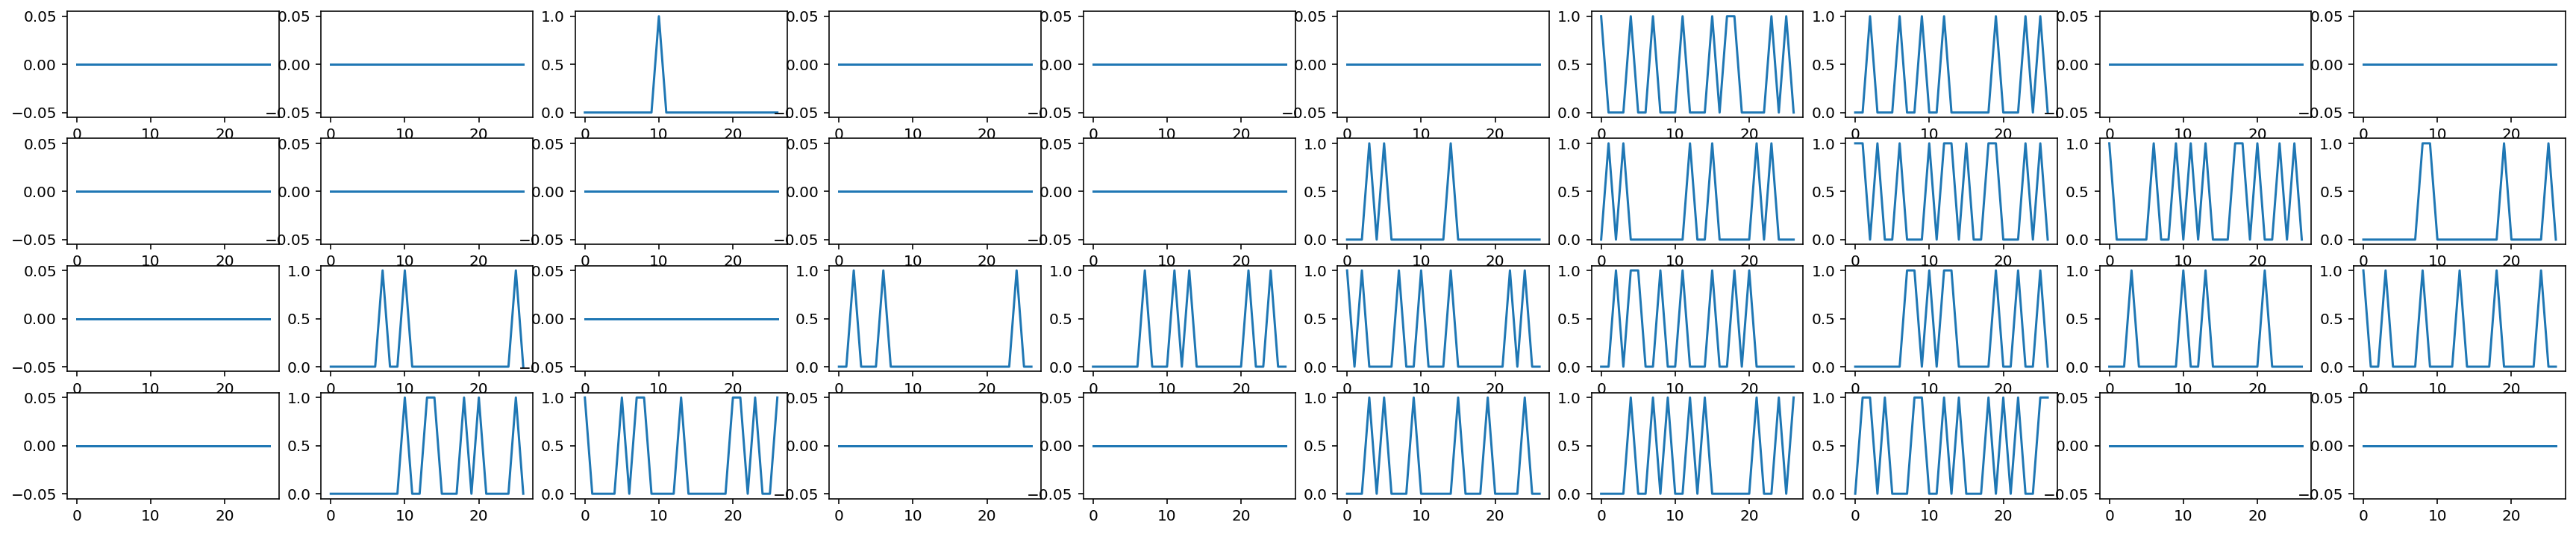

In [10]:
# Plotting the first 10 product from every user
# orange: training-set
# blue: the ground truth to be predicted by the model
f, axes = plt.subplots(4, 10, figsize=(30, 6))
count = 0
for i in range(4):
    for j in range(10):
        if count < len(products):
            axes[i][j].plot(np.array(vectors)[i][:,j])
            count += 1

In [15]:
knet.train(350,1) # weighted training on the CN's

We are going to train 6 networks for 1 epochs with 350 samples each.


In [8]:
#knet.save("saves") # saving a savestate

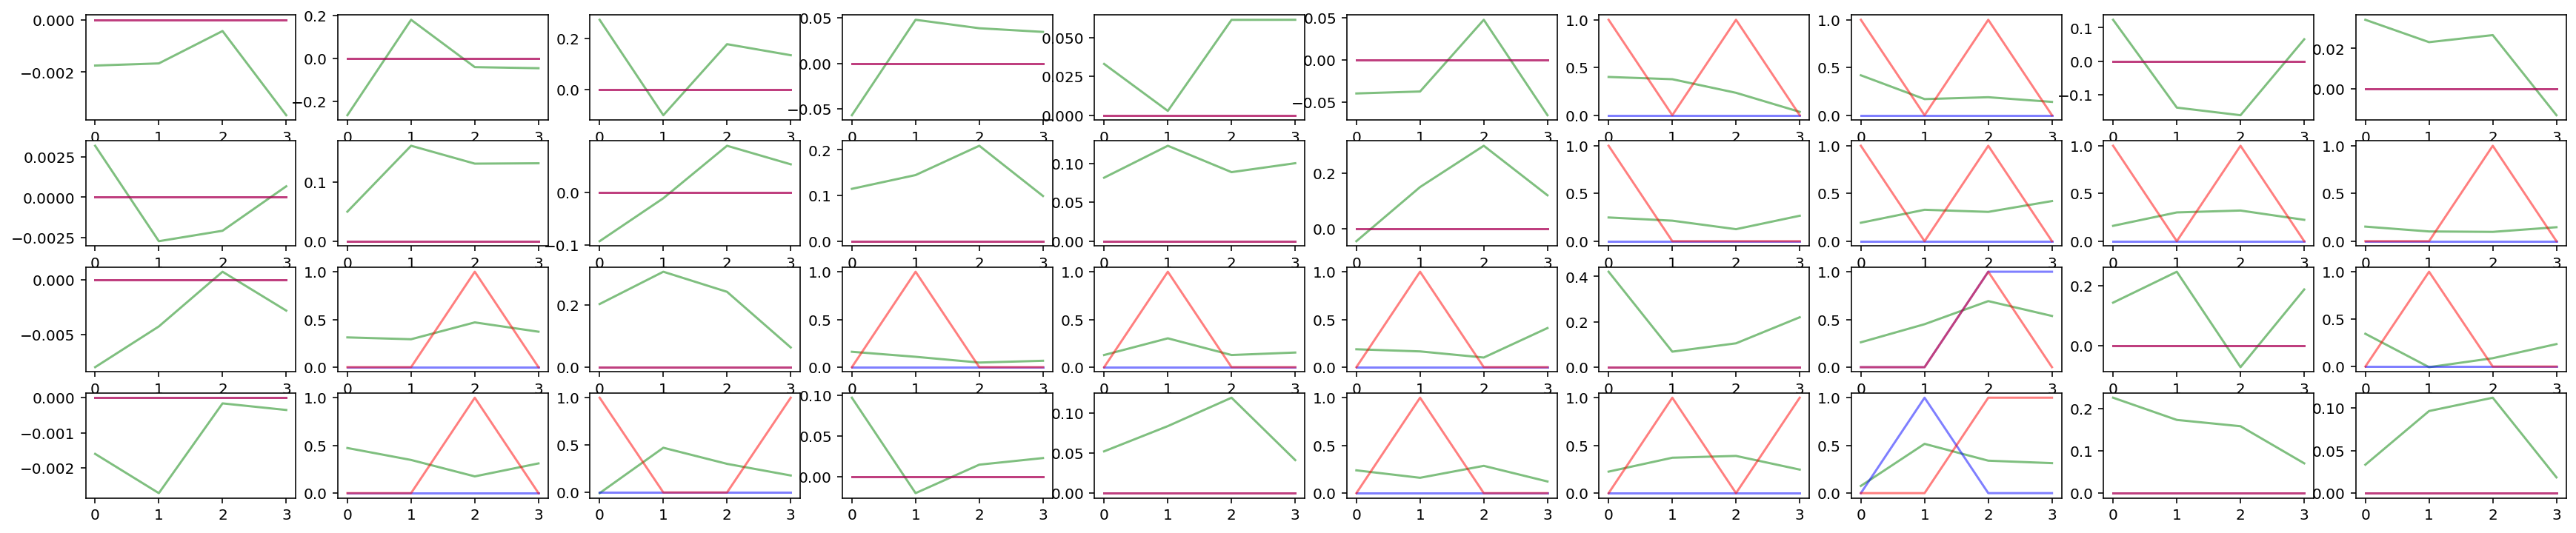

In [16]:
# red: ground truth
# green: prediction
# blue: rounded prediction

f, axes = plt.subplots(4, 10, figsize=(30, 6))
for i in range(4):
    prediction = np.array(np.squeeze(knet.predict(vectors[i], future=4)))
    for j in range(10):
        axes[i][j].plot(prediction[:,j], c='g', alpha=0.5)
        axes[i][j].plot(np.round(prediction[:,j]), alpha=0.5 , c='b')
        axes[i][j].plot(vectors[i][-4:,j], c='r', alpha=0.5)


In [25]:
for user in range(19):
    prediction = np.array(np.squeeze(knet.predict(vectors[user], future=1))) # the prediction for user
    wrong_guesses = np.sum(np.absolute((np.absolute(np.round(prediction)) - vectors[user][-4,:]))) # the right guessed features for one receipt into the future
    false_postives = np.sum(np.maximum((np.absolute(np.round(prediction)) - vectors[user][-4,:]), 0))
    false_negatives = np.sum(np.maximum((vectors[user][-4,:] - np.absolute(np.round(prediction))), 0))
    print(false_postives, false_negatives)
    print("["+ str(user) + "] Accuracy: " + str(len(products)-int(wrong_guesses)) + "/" + str(len(products)) + " (" + str((len(products)-int(wrong_guesses))/len(products)) + ")")

6.0 11.0
[0] Accuracy: 294/311 (0.9453376205787781)
0.0 11.0
[1] Accuracy: 300/311 (0.9646302250803859)
5.0 6.0
[2] Accuracy: 300/311 (0.9646302250803859)
6.0 13.0
[3] Accuracy: 292/311 (0.9389067524115756)
3.0 10.0
[4] Accuracy: 298/311 (0.9581993569131833)
1.0 22.0
[5] Accuracy: 288/311 (0.9260450160771704)
4.0 17.0
[6] Accuracy: 290/311 (0.932475884244373)
3.0 7.0
[7] Accuracy: 301/311 (0.9678456591639871)
3.0 11.0
[8] Accuracy: 297/311 (0.954983922829582)
4.0 10.0
[9] Accuracy: 297/311 (0.954983922829582)
5.0 7.0
[10] Accuracy: 299/311 (0.9614147909967846)
7.0 10.0
[11] Accuracy: 294/311 (0.9453376205787781)
7.0 11.0
[12] Accuracy: 293/311 (0.9421221864951769)
7.0 7.0
[13] Accuracy: 297/311 (0.954983922829582)
8.0 8.0
[14] Accuracy: 295/311 (0.9485530546623794)
0.0 5.0
[15] Accuracy: 306/311 (0.9839228295819936)
1.0 9.0
[16] Accuracy: 301/311 (0.9678456591639871)
1.0 6.0
[17] Accuracy: 304/311 (0.977491961414791)
1.0 7.0
[18] Accuracy: 303/311 (0.9742765273311897)


/home/luan/Schreibtisch/Programmieren/GroceryListPredictor/webapp/precommender/knetworks.py:186: RuntimeWarning: divide by zero encountered in true_divide
  weights = np.minimum((1/distances**2), np.full(distances.shape, 50))


In [23]:
filepath = "saves"
for i, net in enumerate(knet.networks):
    torch.save(net.model.state_dict(), filepath + "/models/CN_" + str(i) + ".pth")
        
# save the centroids array
np.savetxt(filepath + '/centroids.csv', knet.centroids, delimiter=',')
# save the distances array
np.savetxt(filepath + '/distances.csv', knet.D, delimiter=',')
# save the weights array
np.savetxt(filepath + '/weights.csv', knet.W, delimiter=',')